# AdaBoost

AdaBoost 모델은 부스팅 방법을 이용한 모델 중 하나로 Bagging 방법과 달리 미리 정해진 모델 집합을 사용하지 않고 하나의 모형으로 시작해 모형 집합에 포함할 개별 모형을 하나씩 추가하는 방법을 사용하는 분류 모델이다.

이렇게 추가된 모형의 집합을 **commitee**라 하고 개별 모형을 **weak learner**라고 한다.

$$C_1 = \{ k_1 \}$$

$$C_2 = C_1 \cup k_2 = \{ k_1, k_2 \}$$

$$\vdots$$

$$C_m = C_{m-1} \cup k_m = \{ k_1, k_2, \ldots, k_m \}$$

위 식은 부스팅 방법을 이용해 새로운 모형이 하나씩 추가되는 것을 표현한 수식이다.

여기서 $m$번째로 commitee에 추가될 모델 $k_m$의 선택 기준은 바로 이전 단계에 추가된 $C_{m-1}$ 의 성능을 보완하는 것이다.

이렇게 완성된 모델의 집합인 commitee는 다수결 방법이 아닌 각 개별 모형의 출력을 가중치 $\alpha$로 가중선형조합해 판별함수로 사용하게 된다.

추가적으로 부스팅 방법은 이진 분류에만 사용할 수 있어 다음과 같이 부호함수에 따라 양수면 $+1$ 음수면 $-1$을 가지게 된다.

$$y = -1 or 1$$


$$C_{m}(x_i) =  \text{sign} \left( \alpha_1k_1(x_i) + \cdots + \alpha_{m}k_{m}(x_i) \right)$$

AdaBoost의 개별 모형 $k_m$을 선별하는 방법은 다음과 같다.

Train set의 $i$번째 데이터에 가중치 $w_i$를 주어 분류모형 $k_m$이 틀리게 예측한 데이터의 가중치를 합한 값을 손실함수 $L$로 사용한다.

$$L_m = \sum_{i=1}^N w_{m,i} I\left(k_m(x_i) \neq y_i\right)$$

위의 식을 보면 Indicator 함수를 통해 실제 $y_i$의 값이 $k_m$이 예측한 $x_i$와 다를 경우에 1, 맞을 경우에 0을 줌으로써 가중치 $w$가 일종의 벌점의 역할을 하는 것을 확인할 수 있다.

이렇게 commitee $C_m$에 포함될 개별 모델 $k_m$이 선택되면 해당 모델의 투표권 역할을 할 가중치 $\alpha$값을 계산한다.

$$\epsilon_m = \dfrac{\sum_{i=1}^N w_{m,i} I\left(k_m(x_i) \neq y_i\right)}{\sum_{i=1}^N w_{m,i}}$$

위 수식에서 분자는 일종의 시험 성적이, 분모는 총 벌점으로 이해할 수 있다.

즉, 개별 모델의 성능이 좋다면 $\epsilon$ 값은 1에 가까워지고 성능이 나쁘다면 0에 가까워지게 된다.

$$\alpha_m = \frac{1}{2}\log\left( \frac{1 - \epsilon_m}{\epsilon_m}\right)$$

그리고 $\epsilon_m$ 값을 Logit 함수를 이용해 $-\infty \sim + \infty$의 값을 갖도록 하여 최종 $\alpha$값을 반환한다.

여기서 중요한점은 $\alpha$는 사실 $-\infty$ 의 값을 가질 수 있지만 현실적으로 $\epsilon_m$이 0에 가까워 음수는 발생하지 않는다.

데이터에 대한 가중치 $w_{m,i}$는 모든 데이터에 대해 같은 값을 가진다. 하지만 commitee가 증가하면서 그 값이 바뀌게 되는데 다음과 같이 지수함수를 통해 이전 모델 $C_{m-1}$이 맞춘 문제는 작게, 틀린 문제는 크게 확대(boosting)된다.

즉, 이전 모델이 틀린 문제에 초점을 맞춰 다음 모델이 학습을 진행하는 방식으로 모델 집합이 생성된다는 것이다.

$$\begin{split} 
w_{m,i} = w_{m-1,i}  \exp (-y_iC_{m-1}) = 
\begin{cases}
w_{m-1,i}e^{-1}  & \text{ if } C_{m-1} = y_i\\
w_{m-1,i}e & \text{ if } C_{m-1} \neq y_i 
\end{cases}
\end{split}$$

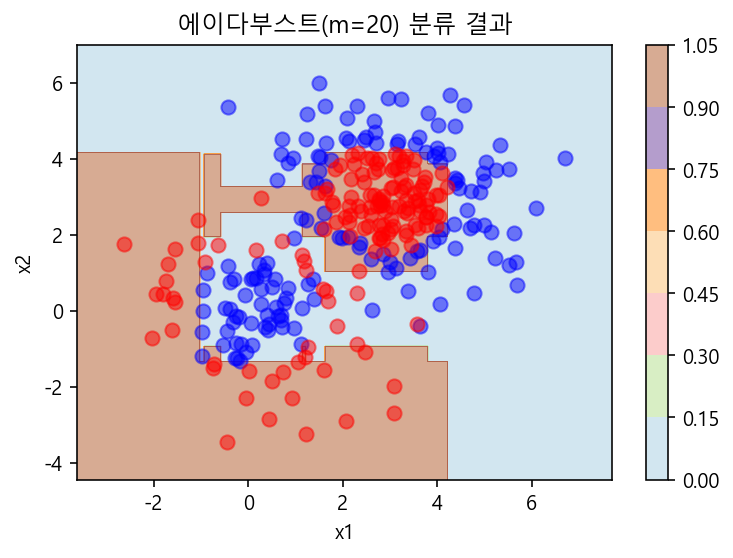

In [194]:
from sklearn.datasets import make_gaussian_quantiles
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier


# 예제용 분류 데이터 생성
X1, y1 = make_gaussian_quantiles(cov=2.,
                                 n_samples=100, n_features=2,
                                 n_classes=2, random_state=1)
X2, y2 = make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=200, n_features=2,
                                 n_classes=2, random_state=1)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, - y2 + 1))


# 가중치를 속성으로 저장하는 코드 추가
class MyAdaBoostClassifier(AdaBoostClassifier):
    
    def __init__(self,
                 base_estimator=None,
                 n_estimators=50,
                 learning_rate=1.,
                 algorithm='SAMME.R',
                 random_state=None):

        super(MyAdaBoostClassifier, self).__init__(
            base_estimator=base_estimator,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            random_state=random_state)
        self.sample_weight = [None] * n_estimators
        
    def _boost(self, iboost, X, y, sample_weight, random_state):
        sample_weight, estimator_weight, estimator_error = \
        super(MyAdaBoostClassifier, self)._boost(iboost, X, y, sample_weight, random_state)
        self.sample_weight[iboost] = sample_weight.copy()
        return sample_weight, estimator_weight, estimator_error

# max_depth를 1로 갖는 DT를 이용해 adaboost 모델 생성
model_ada = MyAdaBoostClassifier(DecisionTreeClassifier(max_depth=1, random_state=0), n_estimators=20)
model_ada.fit(X, y)


# 시각화 함수 작성
def plot_result(model, title="분류결과", legend=False, s=50):
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.02), np.arange(x2_min, x2_max, 0.02))
    if isinstance(model, list):
        Y = model[0].predict(np.c_[xx1.ravel(), xx2.ravel()]).reshape(xx1.shape)
        for i in range(len(model) - 1):
            Y += model[i + 1].predict(np.c_[xx1.ravel(), xx2.ravel()]).reshape(xx1.shape)
    else:
        Y = model.predict(np.c_[xx1.ravel(), xx2.ravel()]).reshape(xx1.shape)
    cs = plt.contourf(xx1, xx2, Y, cmap=plt.cm.Paired, alpha=0.5)
    for i, n, c in zip(range(2), "01", "br"):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=c, s=s, alpha=0.5, label="Class %s" % n)
    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(title)
    plt.colorbar(cs)
    if legend:
        plt.legend()
    plt.grid(False)

plot_result(model_ada, "에이다부스트(m=20) 분류 결과")

실제로 각 weak learner들이 생성하는 분류결과와 특정 데이터의 가중치를 시각화 한 결과는 다음과 같다.

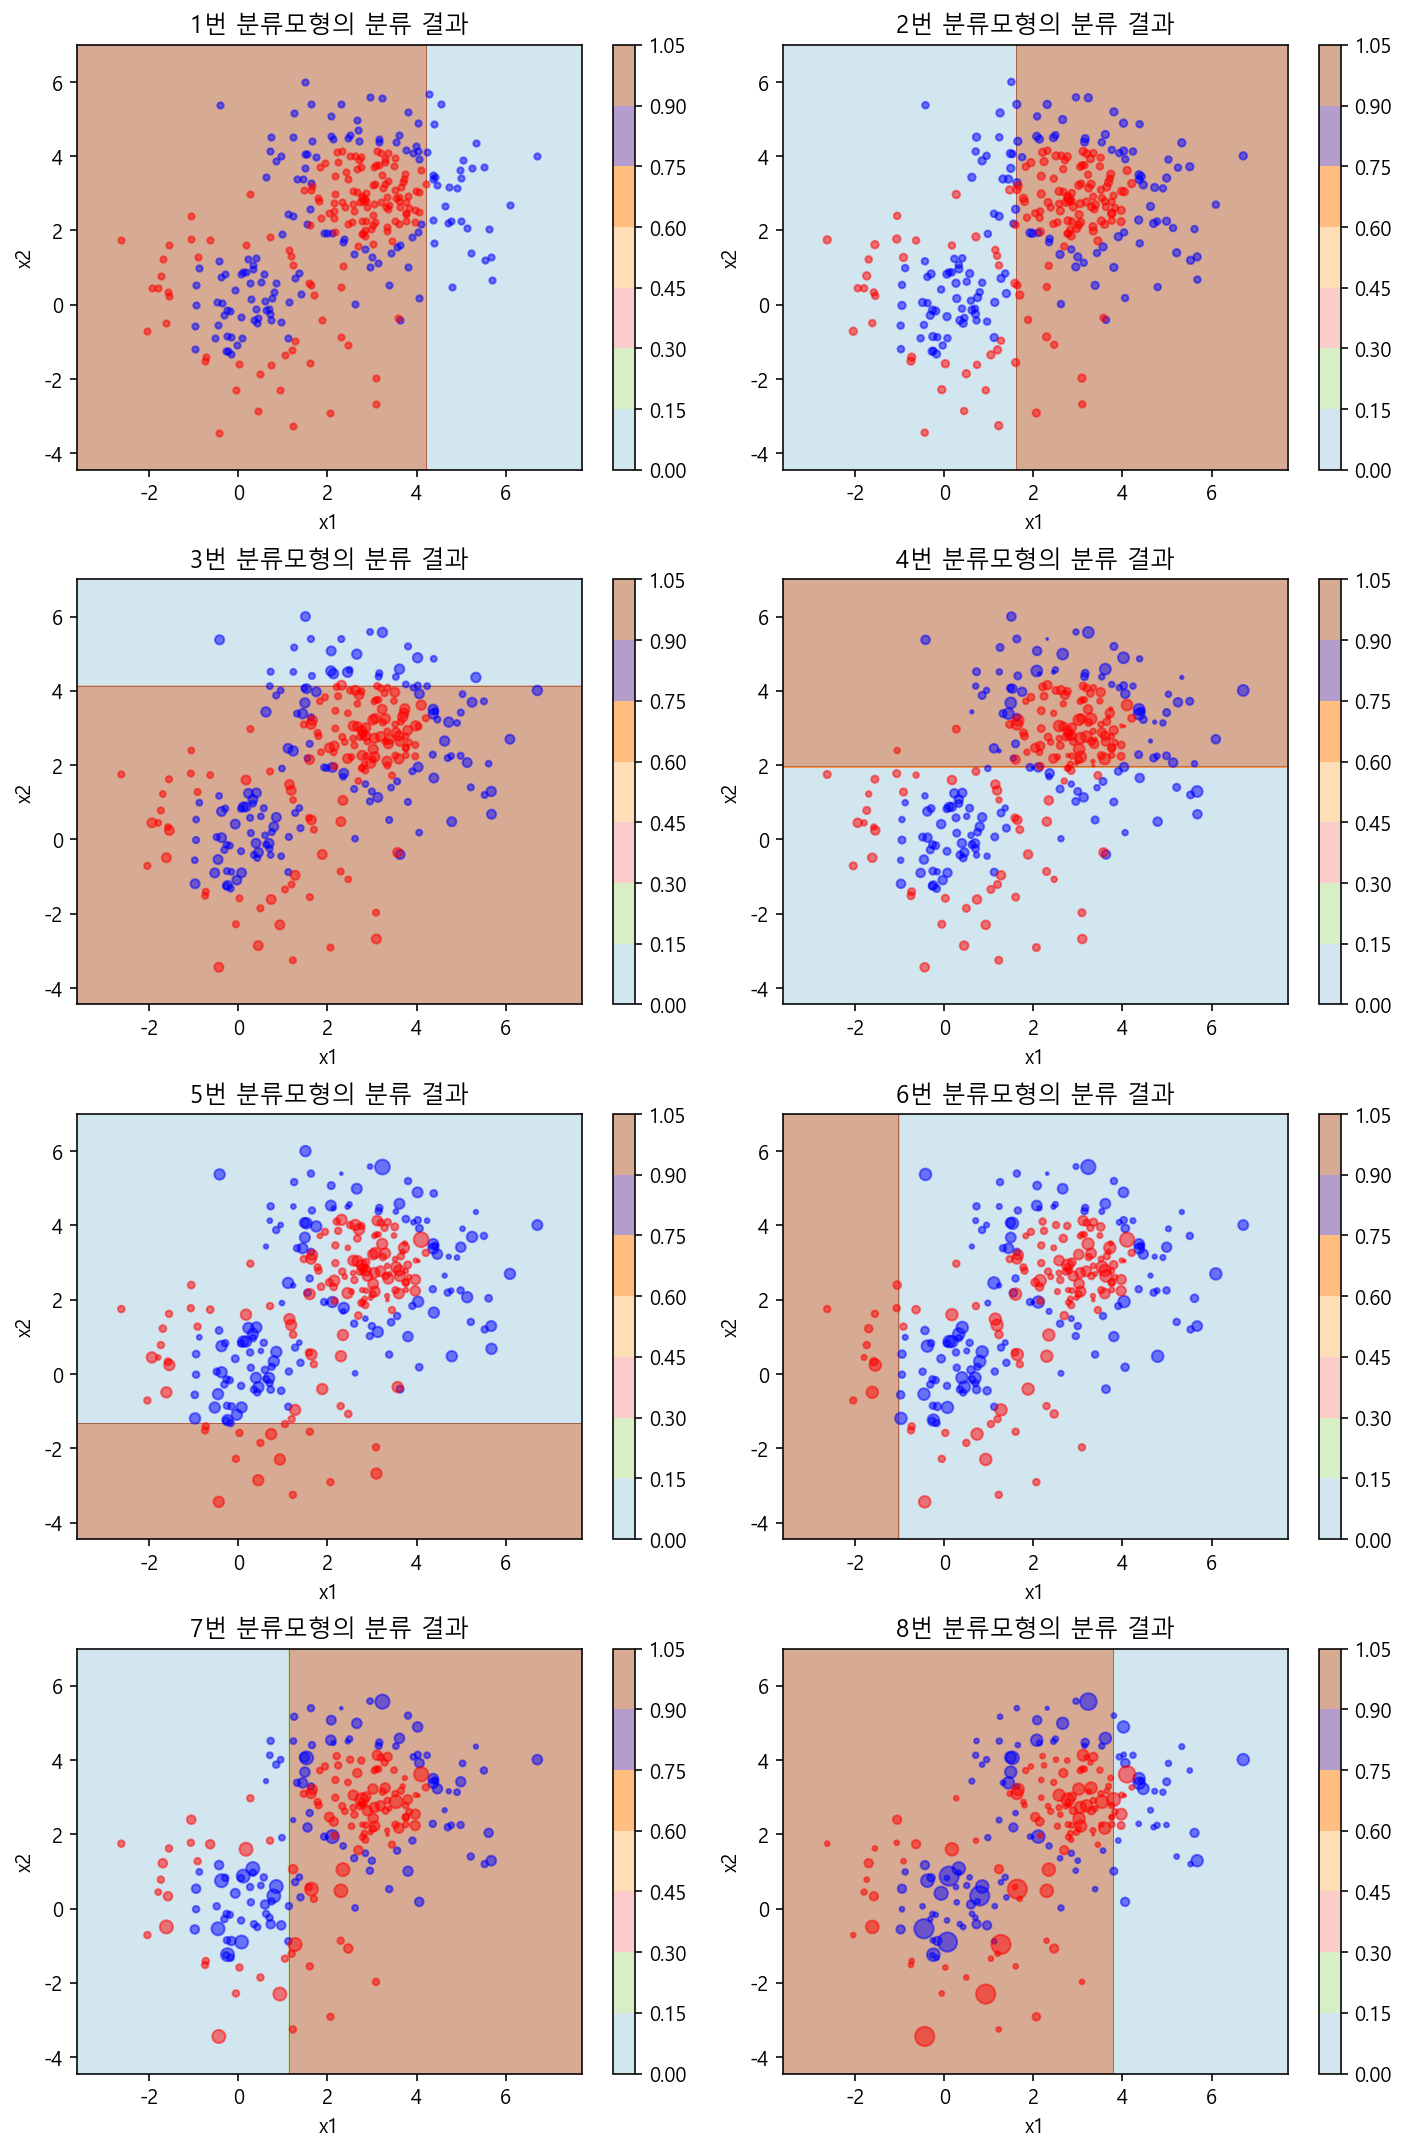

In [186]:
plt.figure(figsize=(10, 15))
plt.subplot(421); 
plot_result(model_ada.estimators_[0], "1번 분류모형의 분류 결과", s=10)
plt.subplot(422); 
plot_result(model_ada.estimators_[1], "2번 분류모형의 분류 결과", s=(4000*model_ada.sample_weight[0][:150]).astype(int))
plt.subplot(423); 
plot_result(model_ada.estimators_[2], "3번 분류모형의 분류 결과", s=(4000*model_ada.sample_weight[1][:150]).astype(int))
plt.subplot(424); 
plot_result(model_ada.estimators_[3], "4번 분류모형의 분류 결과", s=(4000*model_ada.sample_weight[2][:150]).astype(int))
plt.subplot(425); 
plot_result(model_ada.estimators_[4], "5번 분류모형의 분류 결과", s=(4000*model_ada.sample_weight[3][:150]).astype(int))
plt.subplot(426); 
plot_result(model_ada.estimators_[5], "6번 분류모형의 분류 결과", s=(4000*model_ada.sample_weight[4][:150]).astype(int))
plt.subplot(427); 
plot_result(model_ada.estimators_[6], "7번 분류모형의 분류 결과", s=(4000*model_ada.sample_weight[5][:150]).astype(int))
plt.subplot(428); 
plot_result(model_ada.estimators_[7], "8번 분류모형의 분류 결과", s=(4000*model_ada.sample_weight[6][:150]).astype(int))
plt.tight_layout()

하지만 위의 최종 adaboost 모델 분류 결과를 살펴보면 특정 데이터에 너무 fit한 판별선이 확인되며 이는 과적합으로 확인된다.


따라서 과적합 방지를 위해 여러 방법 중 Learning Rate을 조정해 분류결과를 시각화 하면 다음과 같이 과적합이 방지된 모델을 생성할 수 있다.

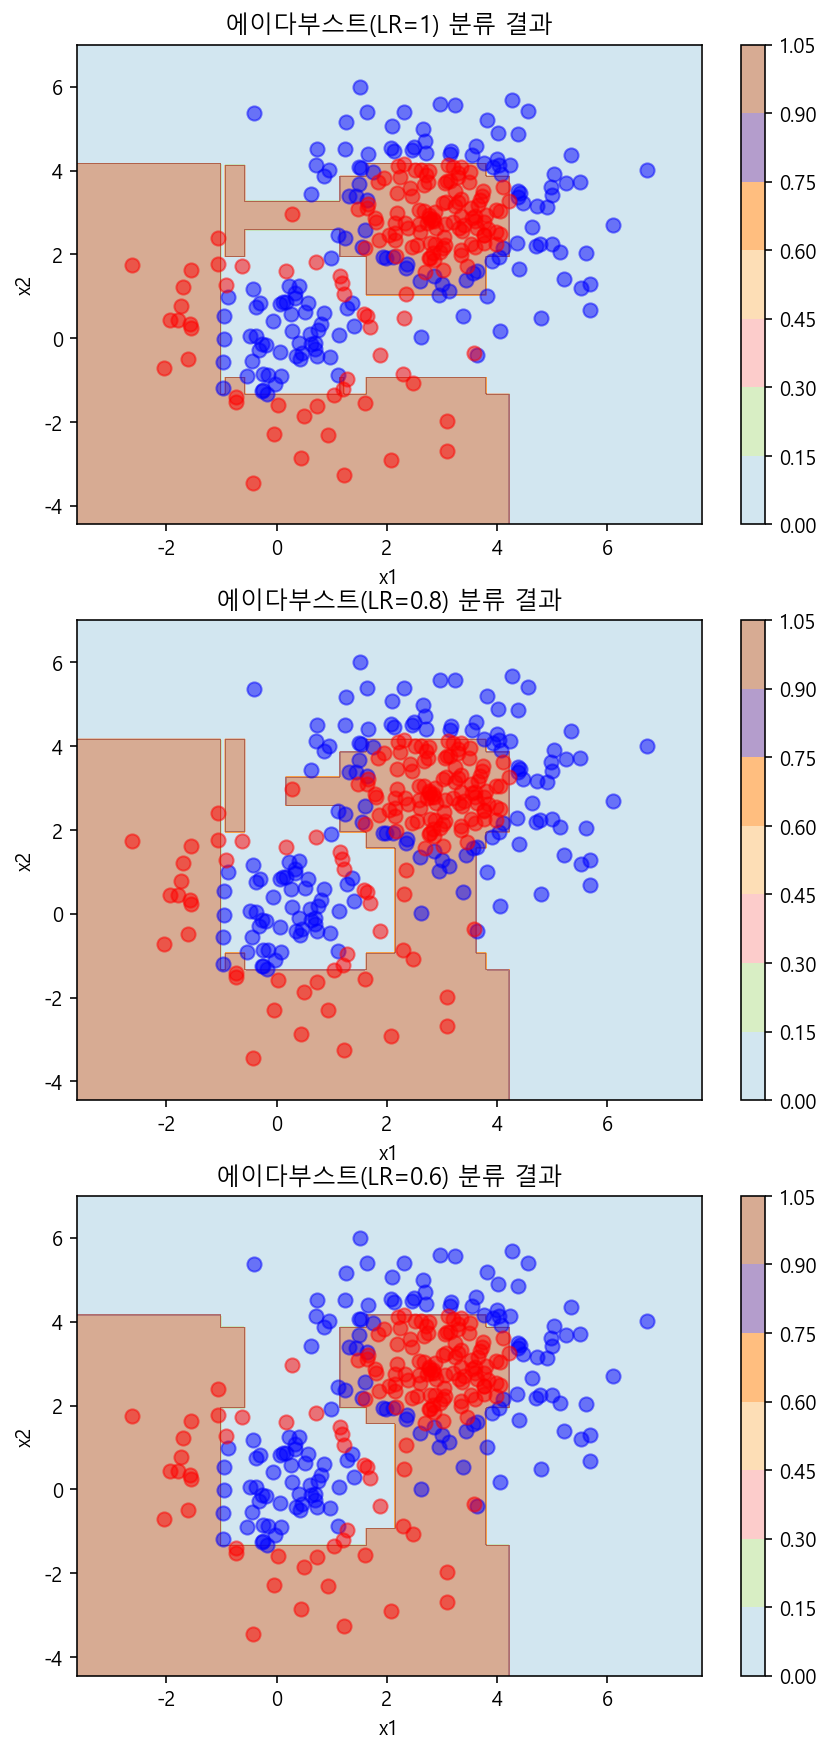

In [208]:
# Learning Rate에 따른 모델 분류 결과 시각화

LR = [1, 0.8, 0.6]
plt.figure(figsize=(7, 15))
for idx, i in enumerate(LR):
    model_ada = MyAdaBoostClassifier(DecisionTreeClassifier(max_depth=1, random_state=0), 
                                     n_estimators=20, learning_rate=i) # LR 조정 과적합 방지
    model_ada.fit(X, y)
    plt.subplot(3,1,idx+1); 
    plot_result(model_ada, "에이다부스트(LR={}) 분류 결과".format(i))